# **Medical Image Generation with Diffusion Models**

## Table of Contents
1. [Introduction to Diffusion Models](#introduction)
2. [Prerequisites](#prerequisites)
3. [Dataset Preparation](#dataset)
4. [Coding the Diffusion Model](#coding-diffusion)
5. [Training](#training)
6. [Testing](#testing)
7. [Inference](#inference)

## 🧪 Introduction to Diffusion Models
<a id="introduction"></a>

In recent years, **diffusion models** have emerged as a powerful class of generative models, rivaling and even surpassing traditional methods like GANs and VAEs in image synthesis tasks. These models generate high-quality images by learning to gradually reverse a noise process—starting from random noise and iteratively denoising it to recover realistic data samples.

This notebook will walk you through the **foundational components of a basic diffusion model**, starting from the **forward noising process**, moving to the **denoising network architecture**, and finally arriving at the **sampling process** used to generate new images. You will get hands-on experience coding the key parts of a DDPM (Denoising Diffusion Probabilistic Model), helping you build both intuition and implementation skills.

We'll begin with a refresher on earlier generative models like GANs and VAEs, and then progressively build toward training a basic diffusion model that can generate images from scratch.

By the end of this session, you will have:
- Understood the theoretical principles behind diffusion models.
- Implemented core components such as the noise scheduler and denoising network.
- Trained a model to generate new samples.
- Explored possible extensions, such as class-conditioning and improved sampling strategies.

> Let's dive into the world of generative AI—one noisy step at a time!

## 📚 Prerequisites
<a id="prerequisites"></a>

Before we begin building diffusion models, it’s important to ensure you're comfortable with the following concepts and tools. This will help you follow along and get the most out of the hands-on coding experience.

### ✅ Technical Knowledge
- **Basic understanding of neural networks** and deep learning workflows.
- Familiarity with **convolutional neural networks (CNNs)**.
- Knowledge of **PyTorch** (especially `nn.Module`, data loaders, training loops).
- Understanding of **loss functions** like MSE, and optimizers like Adam.

### 🧠 Conceptual Foundations
- What are **generative models**? (How they learn to model a data distribution)
- Basic knowledge of **GANs (Generative Adversarial Networks)** and **VAEs (Variational Autoencoders)**.
- Familiarity with **probability distributions** (especially Gaussian/Normal distributions).
- Concept of **adding noise** to data and recovering it through learning.

If you're not familiar with some of these, don't worry—brief refreshers will be provided along the way.

> Let’s now take a quick look at traditional generative models (GANs and VAEs) before introducing diffusion models.


## Building Diffusion Models
### Code Implementation

### Setting Up
* Install and import required libraries
* Define utility function to enable us visualize images
* Define important variables

In [2]:
# Install required Python packages using pip.
# - lightning: for building and training PyTorch models easily
# - torchmetrics: to calculate performance metrics like accuracy, FID, etc.
# - torch-fidelity: for evaluating generative models (e.g., FID score)

# Note: '--no-cache-dir' prevents using cached versions of the packages
!pip install -q --no-cache-dir lightning torchmetrics torch-fidelity

In [32]:
# Import Lightning and PyTorch Lightning utilities
import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint  # For saving the best model

# Import FID metric from TorchMetrics to evaluate generative models
from torchmetrics.image.fid import FrechetInceptionDistance

# Import a helper from Google Colab to display images with OpenCV
from google.colab.patches import cv2_imshow

# Import core PyTorch libraries
import torch
import torch.nn as nn  # For defining neural networks
import torch.optim as optim  # For optimization algorithms like Adam
import torch.utils.data as data  # For data loading and batching
import torch.nn.functional as F  # For functions like relu, softmax, etc.

# Import torchvision tools for data transformation and augmentation
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, Resize

# PIL for image handling
from PIL import Image

# tqdm for showing progress bars
from tqdm.auto import tqdm

# Numpy and matplotlib for numerical operations and visualization
import numpy as np
import matplotlib.pyplot as plt

# Standard libraries
import os
import cv2
import random
import math

# Ignore warning messages to keep the output clean
import warnings
warnings.filterwarnings("ignore")

# Plot settings: inline display and aesthetic customization
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'  # Set background color of plots
plt.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern font for math
plt.rcParams['font.family'] = 'STIXGeneral'  # Use STIX font for consistency

In [4]:
def show_tensor_image(image):
    # Define a series of reverse transforms to convert a normalized tensor image
    # back to a format that can be displayed as a proper image
    reverse_transforms = Compose([
        # Undo normalization from [-1, 1] to [0, 1]
        Lambda(lambda t: (t + 1) / 2),

        # Change shape from [C, H, W] to [H, W, C] for display
        Lambda(lambda t: t.permute(1, 2, 0)),

        # Scale pixel values from [0, 1] to [0, 255]
        Lambda(lambda t: t * 255.),

        # Move tensor to CPU, convert to NumPy array, and change dtype to uint8 for image display
        Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),

        # Convert the NumPy array to a PIL Image
        ToPILImage(),

        # Resize the image to a fixed size (e.g., for consistent display)
        Resize(IMAGE_SIZE),
    ])

    # If the input is a batch of images (4D tensor), take the first one only
    if len(image.shape) == 4:
        image = image[0, :, :, :]  # Select the first image in the batch

    # Turn off axis labels and ticks
    plt.axis('off')

    # Apply reverse transforms and display the image using matplotlib
    plt.imshow(reverse_transforms(image))


In [5]:
MAX_EPOCH = 30
DIFFUSION_STEP = 1000
BATCH_SIZE = 20
LR = 3e-4
CHECKPOINT_DIR = os.getcwd()
IMAGE_SIZE = 48
SCALE_DOWN = 2
N_CHANNEL = 3 #INFO[FLAG]['n_channels']
BETA_START = 1e-4
BETA_END = 2e-2
N_CLASSES = 2# len(INFO[FLAG]['label'])

## 🗂️ Dataset Preparation

### 📥 Adding the Medical MNIST Dataset to Your Kaggle Notebook

Before we begin training our model, we need to make sure the **Medical MNIST** dataset is available in our working environment.

Since we're using **Kaggle Notebooks**, adding a dataset is straightforward and does not require any download or upload. Follow the steps below:

#### ✅ Steps to Add the Dataset from the Notebook

1. **Open Your Kaggle Notebook**
   Make sure you're inside the notebook you'll be working in.

2. **Click on the “Add Input” Panel**
   - Look to the **right side** of your notebook interface.
   - You’ll see a sidebar labeled **“Input,” “Output,” “Table of Contents,” etc.**
   - Click on the **“+ Add Input”** button under the **“Input”** tab.

3. **Search for the Dataset**
   - In the search box that appears, type:  
     ```
     medical mnist
     ```
   - Locate the dataset titled **“Medical MNIST”** (uploaded by `Larxel`).

4. **Attach the Dataset**
   - Click the **“Add” (+)** button next to the dataset name.
   - This will attach the dataset to your notebook under the `/kaggle/input/` directory.


### Processing the Dataset
In this section, we’ll walk through how to **prepare a custom dataset** for training a conditional diffusion model. The goal is to allow our model to learn to generate images from specific classes — *Chest* vs *Hand* X-ray images.

1. **Image Preprocessing**  
   We'll define a transformation pipeline that resizes, normalizes, and converts the images into tensors. This ensures that all images are in the same format and scale before being fed into our model.

2. **Label Formatting (One-Hot Encoding)**  
   Since we’re working with two classes and using a class-conditioned diffusion model, we’ll convert each class label into a **one-hot encoded tensor**. This allows the model to receive class information in a structured and consistent format during training.

3. **Custom Dataset Class**  
   To have more control over which classes are loaded from a dataset, we’ll build a **custom dataset class** by extending `torchvision.datasets.DatasetFolder`. This will allow us to:
   - Filter and load only specific subfolders (i.e., only the desired classes),
   - Apply our transformations,
   - Return both the image and its corresponding one-hot encoded label.


In [6]:
# Define a transformation pipeline to preprocess images before feeding them into a model
image_transform = Compose([
    # Resize the image to a fixed size (IMAGE_SIZE x IMAGE_SIZE)
    Resize((IMAGE_SIZE, IMAGE_SIZE)),

    # Convert the image from PIL or numpy format to a PyTorch tensor
    # This also scales pixel values from [0, 255] to [0.0, 1.0]
    ToTensor(),

    # Normalize the tensor values from [0.0, 1.0] to [-1.0, 1.0]
    Lambda(lambda x: (x * 2) - 1),
])


In [7]:
# This function converts a class label into a one-hot encoded tensor with 2 classes
def one_hot_encode(label):
    # Convert the label (e.g., 0 or 1) to a PyTorch tensor
    # Then apply one-hot encoding with 2 classes (e.g., [1, 0] for class 0, [0, 1] for class 1)
    return F.one_hot(torch.tensor(label), num_classes=2).float()


In [8]:
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
from typing import List, Tuple, Dict
import os

# A custom dataset class that extends torchvision's DatasetFolder
# It filters and loads only images from specified subfolders (i.e., desired classes)
class CustomImageFolder(DatasetFolder):
    def __init__(
        self,
        root: str,                          # Root directory containing class-named folders
        desired_classes: List[str],         # List of class folder names to include
        transform=None,                     # Optional image transformations
        target_transform=None,              # Optional label transformations
        loader=default_loader,              # Function to load an image file
        is_valid_file=None                  # Optional custom file filter
    ):
        self.desired_classes = desired_classes  # Store desired class names
        # Call the parent DatasetFolder constructor with appropriate settings
        super().__init__(
            root,
            loader,
            extensions=('jpg', 'jpeg', 'png'),  # Allowed image formats
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file
        )

    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        """
        Override the default class discovery to include only desired classes.

        Args:
            directory (str): Path to the root dataset directory.

        Returns:
            classes (List[str]): List of selected class folder names.
            class_to_idx (Dict[str, int]): Mapping from class names to indices.
        """
        # Scan the dataset directory and list all subfolders
        all_classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

        # Filter only those that match the desired_classes list
        classes = [cls for cls in all_classes if cls in self.desired_classes]

        # Raise an error if none of the desired classes were found
        if not classes:
            raise FileNotFoundError(
                f"No matching class folders found in {directory}. "
                f"Available: {all_classes}"
            )

        # Create a dictionary mapping class names to integer indices
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        return classes, class_to_idx


In [10]:
dataset = CustomImageFolder(
    root="/kaggle/input/medical-mnist",        # Path to the root directory of the dataset.
                                                # This directory should contain subfolders named after class labels (e.g., "CXR", "Hand", etc.)

    desired_classes=["CXR", "Hand"],            # Only include images from the "CXR" and "Hand" subfolders (i.e., filter by desired classes).

    transform=image_transform,                  # Apply preprocessing to each image:
                                                # - Resize to IMAGE_SIZE x IMAGE_SIZE
                                                # - Convert to tensor
                                                # - Normalize from [0, 1] to [-1, 1]

    target_transform=one_hot_encode             # Apply one-hot encoding to the class label (e.g., 0 -> [1, 0], 1 -> [0, 1])
)


In [11]:
# Print the list of class folder names included in the dataset
# This will only include the classes specified in 'desired_classes' (e.g., ['CXR', 'Hand'])
print(dataset.classes)

# Print the mapping of class names to numerical indices
# This dictionary is used internally to assign numeric labels to each class
print(dataset.class_to_idx)


['CXR', 'Hand']
{'CXR': 0, 'Hand': 1}


In [12]:
# Count the number of samples per class in the dataset
# dataset.targets is a list of class indices for each image (e.g., [0, 0, 1, 0, 1, 1, ...])
class_counts = torch.bincount(torch.tensor(dataset.targets))

# Loop through each class and print its name and corresponding image count
for i, count in enumerate(class_counts):
    # dataset.classes[i] gets the class name (e.g., 'CXR' or 'Hand')
    # count.item() gets the number of images for that class
    print(f"Class: {dataset.classes[i]}, Count: {count.item()}")


Class: CXR, Count: 10000
Class: Hand, Count: 10000


In [13]:
# Step 2: Define the number of samples for validation and test sets
val_size = 4        # Number of samples to reserve for validation
test_size = 4       # Number of samples to reserve for testing

# Compute the number of samples for the training set
# Total = len(dataset), so training = total - val - test
train_size = len(dataset) - val_size - test_size

# Step 3: Randomly split the dataset into training, validation, and test sets
TrainDataset, ValDataset, TestDataset = data.random_split(
    dataset,                         # The full dataset to split
    [train_size, val_size, test_size],  # List of sizes for each split
)

In [14]:
# Get one sample (image and label) from the training dataset
images = TrainDataset[0]  # This returns a tuple: (image_tensor, label_tensor)

# Print the shape of the image tensor
print(images[0].shape)    # Should be something like torch.Size([3, H, W])

# Extract the label from the tuple
label = images[1]         # Can be a one-hot encoded tensor or class index depending on your target_transform

# Print the type of the label (e.g., <class 'torch.Tensor'>)
print(type(label))

# Print the actual label value (e.g., tensor([1., 0.]))
print("label", label)

# Another way to explicitly show the image shape
print(f"Image shape: {images[0].shape}")


torch.Size([3, 48, 48])
<class 'torch.Tensor'>
label tensor([0., 1.])
Image shape: torch.Size([3, 48, 48])


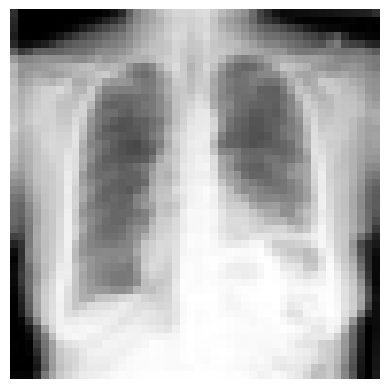

In [15]:
# Initialize an index counter
index = 0

# Iterate through all samples (image, label) in the training dataset
for image, label in TrainDataset:
    
    # Check if the label matches [1., 0.] — i.e., class 0 in one-hot encoding
    # (label == torch.tensor([1., 0.])) returns a boolean tensor, so sum(...) counts how many elements match
    if sum(label == torch.tensor([1., 0.])) > 1:
        
        # If it's a match, increment the counter
        index += 1

        # Display the image using your custom image display function
        show_tensor_image(image)

        # Break after showing more than 5 matching images
        if index > 5:
            break

## Coding the Diffusion Model

In this section, we’ll begin building our **Diffusion Model** — a powerful generative model used for creating high-quality synthetic images. We'll break it down into understandable, modular components so that each part makes sense and can be reused or extended later.


### 🔧 Step-by-Step Breakdown

We'll proceed in the following order:

1. **📊 Utility Function (AverageMeter)**
   - We'll define a simple utility class to keep track of metrics like loss during training.


2. **🌫️ Noise Scheduler**
   - The forward (diffusion) process starts here.
   - This component defines how noise is added to clean images over time (timesteps), simulating the degradation process.


3. **🧱 Core U-Net Architecture**
   - Our model will follow a **U-Net**-like structure, which is commonly used in denoising and image segmentation tasks.
   - We'll implement it **block by block**, building from the ground up:
     - **Self-Attention Block:** Helps the model learn long-range dependencies.
     - **Double Convolution Block:** Applies two successive convolutional layers to capture features.
     - **Downsampling Block:** Reduces spatial resolution and increases feature abstraction.
     - **Upsampling Block:** Restores spatial resolution, guided by features from earlier layers.
     - **Positional Embeddings:** Encodes timestep and context information into the model.


4. **🧩 Assembling the U-Net**
   - All components from step 3 are brought together to construct the full U-Net.

5. **🌀 The Diffusion Model**
   - Here we combine:
     - The **Noise Scheduler** from step 2
     - The **U-Net** model from step 4
   - This results in a complete diffusion system that learns how to **reverse the noise process**, gradually transforming pure noise into meaningful images conditioned on class labels or time.



In [16]:
class AvgMeter(object):
    def __init__(self, num=40):
        """
        Initialize the average meter.

        Args:
            num (int): Number of recent values to keep for computing the average.
        """
        self.num = num  # Limit to the most recent `num` values
        self.reset()    # Initialize/reset the scores list

    def reset(self):
        """
        Clear the stored scores.
        """
        self.scores = []

    def update(self, val):
        """
        Add a new value to the score list.

        Args:
            val (float or tensor): The new value to track.
        """
        self.scores.append(val)

    def show(self):
        """
        Compute and return the average of the most recent `num` values.

        Returns:
            torch.Tensor: The mean of the recent values as a torch scalar.
        """
        # Only use the last `num` values for averaging
        out = torch.mean(
            torch.stack(
                self.scores[np.maximum(len(self.scores) - self.num, 0):]  # Get last `num` elements
            )
        )
        return out


### Noise Scheduler

In [17]:
import torch
import torch.nn as nn

class NoiseScheduler(nn.Module):
    def __init__(
        self,
        T=DIFFUSION_STEP,          # Total number of diffusion steps (e.g., 1000)
        beta_start=BETA_START,     # Starting value of beta (e.g., 1e-4)
        beta_end=BETA_END          # Ending value of beta (e.g., 0.02)
    ):
        super().__init__()

        # Number of timesteps in the diffusion process
        self.T = T

        # Linearly spaced beta schedule: controls the amount of noise added at each step
        self.beta = torch.linspace(beta_start, beta_end, T).to(
            "cuda" if torch.cuda.is_available() else "cpu"
        )

        # alpha = 1 - beta, which represents the amount of original signal preserved at each step
        self.alpha = 1. - self.beta

        # alpha_hat = cumulative product of alpha over time
        # This represents the overall preservation of the original signal up to time t
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def forward(self, x, t):
        """
        Add noise to input `x` based on timestep `t`.

        Args:
            x (Tensor): Original clean image tensor [B, C, H, W]
            t (Tensor): Timestep tensor [B] containing values in [0, T)

        Returns:
            x_noisy (Tensor): Noisy version of the input image
            noise (Tensor): The random noise that was added
        """
        # Reshape alpha_hat[t] to [B, 1, 1, 1] to match image dimensions
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(
            1 - self.alpha_hat[t]
        ).unsqueeze(1).unsqueeze(1).unsqueeze(1)

        # Generate standard Gaussian noise of the same shape as x
        noise = torch.randn_like(x)

        # Create the noisy image using the reparameterization formula:
        # x_noisy = sqrt(alpha_hat) * x + sqrt(1 - alpha_hat) * noise
        x_noisy = sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise

        return x_noisy, noise


In [18]:
FORWARD = NoiseScheduler

### **U-Net**

In [19]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        
        self.channels = channels  # Number of channels in the input (e.g., feature maps)
        self.size = size          # Spatial size (height/width) of the feature map

        # Multi-Head Attention: operates on flattened spatial features
        self.mha = nn.MultiheadAttention(
            embed_dim=channels,     # Each token has 'channels' features
            num_heads=4,            # Number of attention heads
            batch_first=True        # Input/output shape: (B, N, C) instead of default (N, B, C)
        )

        # LayerNorm before attention
        self.ln = nn.LayerNorm([channels])

        # Feed-forward block after attention
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        # Input x: [B, C, H, W]
        
        # Reshape to [B, N, C] where N = H*W (flatten spatial dims), suitable for attention
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)  # => [B, N, C]

        # Apply LayerNorm before attention (standard transformer practice)
        x_ln = self.ln(x)

        # Apply multi-head self-attention: query, key, value are all x_ln
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)

        # Residual connection: Add input x to attention output
        attention_value = attention_value + x

        # Feed-forward network with residual connection
        attention_value = self.ff_self(attention_value) + attention_value

        # Reshape back to original spatial dimensions: [B, C, H, W]
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(
        self, in_channels, out_channels, mid_channels=None, residual=False,
    ):
        super().__init__()
        self.residual = residual  # Whether to use residual connection

        # If no mid_channels is provided, set it equal to out_channels
        if not mid_channels:
            mid_channels = out_channels

        # Define a sequence of two convolutional layers with normalization and GELU activation
        self.double_conv = nn.Sequential(
            nn.Conv2d(
                in_channels, mid_channels, kernel_size=3, padding=1, bias=False
            ),                              # First Conv: in_channels → mid_channels
            nn.GroupNorm(1, mid_channels),  # Group normalization with 1 group (acts like LayerNorm)
            nn.GELU(),                      # GELU activation (smoother than ReLU)

            nn.Conv2d(
                mid_channels, out_channels, kernel_size=3, padding=1, bias=False
            ),                              # Second Conv: mid_channels → out_channels
            nn.GroupNorm(1, out_channels),  # Another GroupNorm
        )

    def forward(self, x):
        # If residual is enabled, add input `x` to the convolutional output before GELU
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


In [21]:
import torch
import torch.nn as nn

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, context_emb_dim=N_CLASSES):
        super().__init__()

        # Downsampling block with:
        # - MaxPooling to reduce spatial resolution by 2
        # - Two DoubleConv layers (first with residual)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),  # Downsample by a factor of 2
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        # Linear layer to embed the time step into a feature map with 'out_channels' dimensions
        self.time_emb_layer = nn.Sequential(
            nn.SiLU(),  # Activation function (Sigmoid-weighted ReLU)
            nn.Linear(time_emb_dim, out_channels),  # Time embedding projection
        )

        # Linear layer to embed the class/context label into the same shape
        self.context_emb_layer = nn.Sequential(
            nn.SiLU(),  # Activation function
            nn.Linear(context_emb_dim, out_channels),  # Context embedding projection
        )

    def forward(self, x, y, t):
        """
        Args:
            x: Input feature map (B, C, H, W)
            y: Context embedding input (e.g., class label vector) → shape (B, context_emb_dim)
            t: Time embedding input (e.g., timestep vector) → shape (B, time_emb_dim)

        Returns:
            A feature map with both time and context conditioning applied.
        """

        # Apply downsampling and convolutional operations
        x = self.maxpool_conv(x)  # Output shape: (B, out_channels, H/2, W/2)

        # Process time embedding and reshape to broadcast over spatial dimensions
        t_emb = self.time_emb_layer(t)[:, :, None, None].repeat(
            1, 1, x.shape[-2], x.shape[-1]
        )

        # Process context (e.g., class embedding) and reshape to broadcast
        y_emb = self.context_emb_layer(y)[:, :, None, None].repeat(
            1, 1, x.shape[-2], x.shape[-1]
        )

        # Apply conditioning: modulate x with y_emb (multiplicative) and t_emb (additive)
        return (y_emb * x) + t_emb


In [22]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, context_emb_dim=N_CLASSES):
        super().__init__()

        # Upsampling operation to increase spatial resolution by a factor of 2
        self.up = nn.Upsample(
            scale_factor=2,
            mode="bilinear",        # Bilinear interpolation for smoother upscaling
            align_corners=True,
        )

        # Double convolution block after upsampling and skip connection concatenation
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),       # Residual double conv
            DoubleConv(in_channels, out_channels, in_channels // 2),   # Standard double conv
        )

        # Project time embedding to match the number of output channels
        self.time_emb_layer = nn.Sequential(
            nn.SiLU(),                      # Activation function
            nn.Linear(time_emb_dim, out_channels),  # Map time embedding → channel space
        )

        # Project context (e.g. class label) embedding to output channels
        self.context_emb_layer = nn.Sequential(
            nn.SiLU(),                             # Activation
            nn.Linear(context_emb_dim, out_channels),  # Map context → channel space
        )

    def forward(self, x, skip_x, y, t):
        """
        Forward pass of the Up block.

        Args:
            x (Tensor): Input feature map from the previous layer [B, C, H, W]
            skip_x (Tensor): Feature map from the encoder for skip connection [B, C_skip, H, W]
            y (Tensor): Context embedding [B, context_emb_dim]
            t (Tensor): Time embedding [B, time_emb_dim]

        Returns:
            Tensor: Output feature map with conditioning applied
        """

        # Upsample the input
        x = self.up(x)

        # Concatenate the skip connection from encoder (along channel dimension)
        x = torch.cat([skip_x, x], dim=1)  # Shape: [B, C_skip + C, H, W]

        # Apply convolutional layers
        x = self.conv(x)

        # Expand time embedding to spatial dimensions and match channels
        t_emb = self.time_emb_layer(t)[:, :, None, None].repeat(
            1, 1, x.shape[-2], x.shape[-1]
        )

        # Expand context embedding to spatial dimensions
        y_emb = self.context_emb_layer(y)[:, :, None, None].repeat(
            1, 1, x.shape[-2], x.shape[-1]
        )

        # Apply context as multiplicative modulation, and time as additive bias
        return (y_emb * x) + t_emb


In [23]:
import torch
import torch.nn as nn

class PositionalEmbedding(nn.Module):
    def __init__(
        self,
        channels,
        device="cuda" if torch.cuda.is_available() else "cpu",
    ):
        super().__init__()
        self.channels = channels  # Dimensionality of the embedding vector
        self.device = device      # Device to place tensors on (e.g., "cuda" or "cpu")

    def forward(self, time):
        """
        Converts a scalar time tensor into a sinusoidal positional embedding.

        Args:
            time (Tensor): A tensor of shape [B, 1] or [B] representing timesteps.

        Returns:
            Tensor: A positional embedding of shape [B, channels]
        """

        # Compute inverse frequencies for sinusoidal functions:
        # inv_freq = [1/10000^(2i/channels) for i in (0, 2, 4, ...)]
        inv_freq = 1.0 / (
            10000 ** (
                torch.arange(0, self.channels, 2, device=self.device).float() / self.channels
            )
        )

        # Make sure time has shape [B, 1] for broadcasting
        time = time.unsqueeze(1) if time.dim() == 1 else time

        # Repeat time values to match the number of frequencies
        # Apply sin to even indices, cos to odd indices
        pos_enc_a = torch.sin(time * inv_freq)  # shape: [B, channels//2]
        pos_enc_b = torch.cos(time * inv_freq)  # shape: [B, channels//2]

        # Concatenate sin and cos components to get the full positional embedding
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)  # shape: [B, channels]

        return pos_enc


In [24]:
class UNet(nn.Module):
    def __init__(
        self,
        c_in=N_CHANNEL,                          # Number of input channels (e.g., 3 for RGB)
        c_out=N_CHANNEL,                         # Number of output channels
        time_dim=256 // SCALE_DOWN,              # Dimensionality of time embeddings
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        super().__init__()

        # Initial convolutional block
        self.input_conv = DoubleConv(c_in, 64 // SCALE_DOWN)

        # Encoder (Downsampling path)
        self.down1 = Down(64 // SCALE_DOWN, 128 // SCALE_DOWN, time_dim)
        self.sa1 = SelfAttention(128 // SCALE_DOWN, IMAGE_SIZE // 2)  # Self-attention after down1

        self.down2 = Down(128 // SCALE_DOWN, 256 // SCALE_DOWN, time_dim)
        self.sa2 = SelfAttention(256 // SCALE_DOWN, IMAGE_SIZE // 4)

        self.down3 = Down(256 // SCALE_DOWN, 256 // SCALE_DOWN, time_dim)
        self.sa3 = SelfAttention(256 // SCALE_DOWN, IMAGE_SIZE // 8)

        # Bridge (bottleneck)
        self.bridge1 = DoubleConv(256 // SCALE_DOWN, 512 // SCALE_DOWN)
        self.bridge2 = DoubleConv(512 // SCALE_DOWN, 512 // SCALE_DOWN)
        self.bridge3 = DoubleConv(512 // SCALE_DOWN, 256 // SCALE_DOWN)

        # Decoder (Upsampling path)
        self.up1 = Up(512 // SCALE_DOWN, 128 // SCALE_DOWN, time_dim)
        self.sa4 = SelfAttention(128 // SCALE_DOWN, IMAGE_SIZE // 4)

        self.up2 = Up(256 // SCALE_DOWN, 64 // SCALE_DOWN, time_dim)
        self.sa5 = SelfAttention(64 // SCALE_DOWN, IMAGE_SIZE // 2)

        self.up3 = Up(128 // SCALE_DOWN, 64 // SCALE_DOWN, time_dim)
        self.sa6 = SelfAttention(64 // SCALE_DOWN, IMAGE_SIZE)

        # Final convolution to produce output image
        self.out_conv = nn.Conv2d(64 // SCALE_DOWN, c_out, kernel_size=1)

        # Time positional encoding (used to condition the model on timestep `t`)
        self.pos_encoding = PositionalEmbedding(time_dim, device)

    def forward(self, x, y, t):
        """
        Forward pass of the conditional U-Net.

        Args:
            x: Input image tensor (B, C, H, W)
            y: Class embedding or one-hot vector (B, N_CLASSES)
            t: Time step tensor (B)

        Returns:
            Tensor: Output image tensor (B, C_out, H, W)
        """
        # Expand and encode the time embedding
        t = t.unsqueeze(-1).type(torch.float)     # Ensure shape [B, 1]
        t = self.pos_encoding(t)                  # Get time embedding [B, time_dim]

        # Downsampling path
        x1 = self.input_conv(x)                   # Initial conv
        x2 = self.down1(x1, y, t)
        x2 = self.sa1(x2)

        x3 = self.down2(x2, y, t)
        x3 = self.sa2(x3)

        x4 = self.down3(x3, y, t)
        x4 = self.sa3(x4)

        # Bottleneck (bridge)
        x4 = self.bridge1(x4)
        x4 = self.bridge2(x4)
        x4 = self.bridge3(x4)

        # Upsampling path with skip connections
        x = self.up1(x4, x3, y, t)
        x = self.sa4(x)

        x = self.up2(x, x2, y, t)
        x = self.sa5(x)

        x = self.up3(x, x1, y, t)
        x = self.sa6(x)

        # Final output layer
        output = self.out_conv(x)

        return output


In [25]:
BACKWARD = UNet

### **Wrapper**

In [33]:
class DiffusionModel(L.LightningModule):
    def __init__(self, forward_model, backward_model, batch_size, lr, max_epoch):
        super().__init__()
        
        # Diffusion models
        self.forward_model = forward_model  # Noise scheduler
        self.backward_model = backward_model  # Denoising UNet

        # Training parameters
        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        # Manual optimization
        self.automatic_optimization = False

        # Metrics
        self.model_loss = []
        self.val_fid = []

        self.model_loss_recorder = AvgMeter()
        self.val_fid_recorder = AvgMeter()

        self._device = "cuda" if torch.cuda.is_available() else "cpu"
        self._T = self.forward_model.T

        # FID computation
        self.fid = FrechetInceptionDistance(
            feature=64,
            input_img_size=(N_CHANNEL, IMAGE_SIZE, IMAGE_SIZE),
            normalize=True
        )

    def forward(self, x=None, y=None, t=None):
        # Training: return MSE loss between predicted and true noise
        if self.training:
            x_noisy, noise = self.forward_model(x, t)
            noise_pred = self.backward_model(x_noisy, y, t)
            return F.mse_loss(noise, noise_pred)
        else:
            # Sampling mode during validation or inference
            return self.sample(progress=False, verbose=True)

    def sample(self, n=1, context=None, progress=False, verbose=False, n_progress=5):
        self.backward_model.eval()

        # If no context is provided, randomly generate one-hot class context
        context = F.one_hot(torch.tensor(np.random.randint(0, 2), dtype=torch.int64),
                            num_classes=N_CLASSES).float() if context is None else context

        progress_image = [] if progress else None

        with torch.no_grad():
            x = torch.randn((n, N_CHANNEL, IMAGE_SIZE, IMAGE_SIZE)).to(self.device)

            if progress:
                progress_image.append(x.detach().cpu())

            iteration = tqdm(reversed(range(0, self._T)), position=0) if verbose else reversed(range(0, self._T))

            for i in iteration:
                t = (torch.ones(n) * i).long().to(self.device)

                noise_pred = self.backward_model(x, context, t)

                alpha = self.forward_model.alpha[t][:, None, None, None]
                alpha_hat = self.forward_model.alpha_hat[t][:, None, None, None]
                beta = self.forward_model.beta[t][:, None, None, None]

                noise = torch.randn_like(x) if i else torch.zeros_like(x)

                # Reverse process (denoising step)
                x = (
                    1 / torch.sqrt(alpha) *
                    (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * noise_pred) +
                    torch.sqrt(beta) * noise
                )
                x = torch.clamp(x, -1.0, 1.0)

                if progress and i % (self._T // n_progress) == 0:
                    progress_image.append(x.detach().cpu())

            if progress:
                progress_image.pop(n_progress // 2)
                return progress_image

        return x

    def on_train_epoch_start(self):
        self.fid.reset()

    def training_step(self, batch, batch_nb):
        x, y = batch

        self.fid.update((x + 1.0) / 2.0, real=True)

        t = torch.randint(0, self._T, (self.batch_size,), device=self._device).long()
        loss = self(x, y, t)

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("model_loss", loss, prog_bar=True)
        self.model_loss_recorder.update(loss.data)

    def on_train_epoch_end(self):
        self.model_loss.append(self.model_loss_recorder.show().data.cpu().numpy())
        self.model_loss_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        self.fid.update((x + 1.0) / 2.0, real=True)

        _x = self.sample(x.shape[0], y)
        self.fid.update((_x + 1.0) / 2.0, real=False)

        fid = self.fid.compute().data.cpu()
        self.log("val_fid", fid, prog_bar=True)
        self.val_fid_recorder.update(fid)

    def on_validation_epoch_end(self):
        self.val_fid.append(self.val_fid_recorder.show().data.cpu().numpy())
        self.val_fid_recorder = AvgMeter()

    def test_step(self, batch, batch_nb):
        x, y = batch
        self.fid.update((x + 1.0) / 2.0, real=True)

        _x = self.sample(x.shape[0], y)
        self.fid.update((_x + 1.0) / 2.0, real=False)

    def on_test_epoch_end(self):
        fid = self.fid.compute().data.cpu()
        self.log("test_fid", fid, prog_bar=False, logger=True)

    def on_train_end(self):
        # Plot training loss
        loss_img_file = f"/content/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.model_loss, color="r")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Plot FID metric over epochs
        evaluation_metric_img_file = f"/content/{MODEL_NAME}_fid_plot.png"
        plt.plot(self.val_fid[1:], color="b")
        plt.title("FID Curves")
        plt.xlabel("Epoch")
        plt.ylabel("FID")
        plt.grid()
        plt.savefig(evaluation_metric_img_file)
        plt.clf()
        img = cv2.imread(evaluation_metric_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=2,
            shuffle=True,
            drop_last=True
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=2,
            shuffle=True,
            drop_last=True
        )

    def configure_optimizers(self):
        return [optim.AdamW(self.parameters(), lr=self.lr)]


In [34]:
MODEL_NAME = DiffusionModel.__name__

In [35]:
load_pretrained = False  # Set to True to load from a saved checkpoint
checkpoint_path = None

if load_pretrained:
    print("Loading pre-weights...")

    # Load the pretrained model from a checkpoint file using PyTorch Lightning
    model = DiffusionModel.load_from_checkpoint(
        checkpoint_path=checkpoint_path,  # Path to the saved checkpoint

        # Map the model to the appropriate device (GPU if available, else CPU)
        map_location="cuda" if torch.cuda.is_available() else "cpu",

        # Required arguments for rebuilding the model instance (must match constructor)
        forward_model=FORWARD(),         # Forward diffusion scheduler
        backward_model=BACKWARD(),       # Backward (UNet) model
        batch_size=BATCH_SIZE,           # Batch size during training/inference
        lr=LR,                           # Learning rate
        max_epoch=MAX_EPOCH,             # Total training epochs
    )
else:
    # Fresh initialization of the model from scratch
    model = DiffusionModel(FORWARD(), BACKWARD(), 32, LR, MAX_EPOCH)

## **Training**

In [ ]:
# Define a checkpoint callback to save the best model based on validation FID
checkpoint = ModelCheckpoint(
    monitor='val_fid',            # Metric to monitor
    dirpath=CHECKPOINT_DIR,       # Directory to save checkpoint files
    mode='min',                   # Lower FID = better
)

# Create a Lightning Trainer object with desired settings
trainer = Trainer(
    accelerator="auto",           # Automatically choose GPU/CPU
    devices=1,                    # Use 1 GPU or 1 CPU
    max_epochs=30,                # Total training epochs
    callbacks=[checkpoint],       # Use ModelCheckpoint callback
    log_every_n_steps=5,          # Log metrics every 5 steps
    check_val_every_n_epoch=5,    # Run validation every 5 epochs
)

# Begin training the model
trainer.fit(model)



2025-05-26 22:09:24.826272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748297365.246892      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748297365.374367      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: 
  | Name           | Type                     | Params | Mode 
--------------------------------------------------------------------
0 | forward_model  | NoiseScheduler           | 0      | train
1 | backward_model | UNet                     | 5.8 M  | train
2 | fid            | FrechetInceptionDistance | 23.9 M | train
--------------------------------------------------------------------
5.8 M     Trainable params
23.9 M    Non

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

## **Testing**

In [ ]:
# Rename the best model checkpoint to a custom file name for easier identification
os.rename(
    checkpoint.best_model_path,                                     # Original path (auto-named by PyTorch Lightning)
    os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt")         # New path with custom name
)


In [ ]:
# Set model to evaluation mode to disable dropout, batchnorm updates, etc.
model.eval()

# Run the test step using the best saved checkpoint
trainer.test(
    ckpt_path=os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt")
)


## **Inference**

### **Utils**

In [ ]:
CHECKPOINT_INFERENCE = os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt")

In [ ]:
N_SAMPLE = 5

In [ ]:
# Load the pretrained diffusion model from a checkpoint
model = DiffusionModel.load_from_checkpoint(
    checkpoint_path=CHECKPOINT_INFERENCE,  # Path to your saved .ckpt file
    map_location="cuda" if torch.cuda.is_available() else "cpu",  # Load onto the correct device
    forward_model=FORWARD(),         # Reconstruct the forward noise scheduler
    backward_model=BACKWARD(),       # Reconstruct the backward UNet
    batch_size=BATCH_SIZE,           # Must match what was used during training
    lr=LR,                           # Learning rate used at training
    max_epoch=MAX_EPOCH              # Total epochs used in training
)

# Set model to evaluation mode to disable training-specific behavior (e.g., dropout)
model.eval()

print("done")

### Visualize

In [ ]:
samples_per_class = 10  # Number of samples to generate per class

for class_id in range(0, 2):  # Loop through all classes (e.g., 0 and 1)
    # Create one-hot class label and move to CUDA
    class_label = F.one_hot(torch.tensor(class_id, dtype=torch.int64), num_classes=N_CLASSES).float().to("cuda")
    class_label = class_label.unsqueeze(0)  # Shape: [1, N_CLASSES]
    
    print(f"\nClass {class_id} one-hot:", class_label)

    model.eval()  # Ensure model is in inference mode

    for sample_idx in range(samples_per_class):
        plt.figure(figsize=(5, 5))  # Set figure size for clarity

        # Generate 1 sample with the given class condition
        generated = model.sample(
            n=1,
            context=class_label,
            progress=False,
            verbose=False,
            n_progress=5
        )

        # Extract image from batch (shape: [1, C, H, W]) → [C, H, W]
        image = generated[0] if isinstance(generated, list) else generated[0, :, :, :]

        # Show the generated image
        show_tensor_image(image)